In [121]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import clone
import os
from datetime import datetime

In [122]:
# CONTROLS

#model = LogisticRegression(max_iter=10000)
model = RandomForestClassifier()
#model = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False)

#missingness_threshold = 0.9
#missingness_threshold = 0.75
missingness_threshold = 0.5
#missingness_threshold = 0.25

#outcome = 'alc_postlt'
outcome = 'harmfuldrink'

#imputation_strategy = '-1'
imputation_strategy = 'mode'
#imputation_strategy = None # only for XGBoost

#patient_questions_only = True
patient_questions_only = False

include_feature_selection = True
#include_feature_selection = False

save_results = True
#save_results = False

In [123]:
df = pd.read_stata('./data/psychosocial_data.dta') # read in questions
print(df.shape)
df.head(11)

(205, 1721)


id  nid  q1  q2  q3  q4  q5  q6  q7  q8  q9  q10  q11  q12  q13  q14  q15  \
0    1   47   7   2   1   1   1   0   0   0   0    1  NaN  NaN    1  1.0  1.0   
1    2   48   7   2   1   1   1   0   0   0   0    1  NaN  NaN    2  NaN  0.0   
2    3   49   5   2   0   1   1   0   0   0   0    1  NaN  NaN    1  NaN  0.0   
3    4   81   8   2   1   0   1   0   0   0   0    1  NaN  NaN    2  1.0  1.0   
4    5   82  13   2   1   1   1   0   0   0   1    1  NaN  NaN    2  1.0  0.0   
5    6   90  10   2   1   1   1   0   0   0   0    1  NaN  NaN    2  NaN  0.0   
6    7   91   5   2   1   0   1   0   0   0   0    1  NaN  NaN    1  NaN  0.0   
7    8   23   8   2   1   1   1   0   0   0   1    1  NaN  NaN    2  1.0  1.0   
8    9   93  10   2   1   1   1   0   0   0   1    1  NaN  NaN    1  1.0  1.0   
9   10   94   7   2   0   1   1   0   0   0   0    1  NaN  NaN    2  NaN  0.0   
10  10   95  13   0   1   1   1   0   0   0   0    1  NaN  NaN    0  NaN  0.0   

    q16  q17  q18  q19  q20  q21  q22  q23  q24  q25  q26  q27  q28  q29  q30  \
0   NaN  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
1   2.0  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
2   2.0  NaN  NaN  NaN  0.0  0.0    0  NaN  NaN  0.0    0  NaN    2  NaN  NaN   
3   2.0  NaN  NaN  NaN  0.0  0.0    0  1.0  NaN  0.0    0  NaN    2  NaN  NaN   
4   2.0  NaN  NaN  NaN  0.0  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
5   2.0  NaN  NaN  NaN  0.0  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
6   2.0  NaN  NaN  0.0  0.0  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
7   NaN  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  0.0    0  NaN    0  NaN  NaN   
8   NaN  NaN  NaN  NaN  NaN  NaN    0  0.0  NaN  0.0    0  1.0    0  NaN  NaN   
9   NaN  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  0.0    0  2.0    0  NaN  NaN   
10  2.0  1.0  1.0  NaN  0.0  0.0    1  1.0  NaN  0.0    0  NaN    0  NaN  NaN   

    q31  q32  q33  q34  q35  q36  q37  q38  q39  q40  q41  q42  q43  q44  q45  \
0   NaN  NaN    0  NaN  0.0  NaN  3.0  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN   
1   NaN  NaN    0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
2   0.0  NaN    0  NaN  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3   NaN  NaN    0  NaN  0.0  0.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4   NaN  NaN    0  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  0.0  NaN   
5   NaN  NaN    0  NaN  0.0  0.0  NaN  NaN  NaN  NaN  1.0  NaN  0.0  NaN  NaN   
6   1.0  NaN    0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN   
7   1.0  1.0    0  NaN  0.0  0.0  3.0  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN   
8   NaN  NaN    0  NaN  0.0  0.0  2.0  NaN  1.0  2.0  1.0  0.0  NaN  0.0  NaN   
9   NaN  NaN    0  NaN  0.0  0.0  3.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
10  NaN  NaN    1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN   

    q46  q47  q48  q49  q50  q51  q52  q53  q54  q55  q56  q57  q58  q59  q60  \
0   NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  1.0  NaN   
1   NaN  0.0  0.0  0.0  0.0  1.0  NaN  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN   
2   NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  0.0  NaN  NaN  NaN   
3   1.0  NaN  0.0  0.0  NaN  0.0  0.0  0.0  0.0  NaN  NaN  NaN  0.0  0.0  NaN   
4   1.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5   NaN  NaN  1.0  NaN  NaN  1.0  1.0  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN   
6   NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN   
7   NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN   
8   NaN  NaN  NaN  1.0  NaN  0.0  0.0  1.0  0.0  0.0  NaN  NaN  NaN  1.0  NaN   
9   NaN  NaN  NaN  1.0  NaN  0.0  0.0  1.0  NaN  NaN  NaN  NaN  NaN  1.0  NaN   
10  NaN  NaN  NaN  1.0  NaN  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   

    q61  q62  q63  q64  q65  q66  q67  q68  q69  q70  q71   q72   q73   q74  \
0   NaN  NaN  NaN  NaN  NaN  NaN 

In [124]:
question_data = df.filter(regex='^q[0-9]{1,3}$',axis=1) # filter to columns containing the 199 questions asked
question_data = pd.concat([question_data, df[['id', 'nid']]], axis=1) # keep id and nid columns
question_data.shape

(205, 201)

In [125]:
non_patient_questions = ['q1','q2','q3','q4','q5','q6','q7','q8','q9','q10','q12','q22',
                         'q33','q71','q129','q130','q145','q198']
mixed_questions = ['q28','q70','q146'] # 0 and NaN mean missing value
special_mixed_questions = ['q27','q40'] # only NaN means missing value

if patient_questions_only:
    question_data.drop(columns=non_patient_questions+mixed_questions+special_mixed_questions, inplace=True)
else: # split mixed questions
    def mixed_question_splitter(row, q): # return 1 if question has non-zero and non-null value
        if np.isnan(row[q]) or row[q] == 0:
            return 0
        return 1
    
    for q in mixed_questions: 
        new_label = q + '_split'
        question_data[new_label] = df.apply(lambda row: mixed_question_splitter(row, q), axis=1)
        
    def special_mixed_question_splitter(row, q): # return 1 if question has only non-null value
        if np.isnan(row[q]):
            return 0
        return 1
        
    for q in special_mixed_questions: 
        new_label = q + '_split'
        question_data[new_label] = df.apply(lambda row: special_mixed_question_splitter(row, q), axis=1)
    
question_data.shape

(205, 206)

In [126]:
question_data.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20,q21,q22,q23,q24,q25,q26,q27,q28,q29,q30,q31,q32,q33,q34,q35,q36,q37,q38,q39,q40,q41,q42,q43,q44,q45,q46,q47,q48,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q59,q60,q61,q62,q63,q64,q65,q66,q67,q68,q69,q70,q71,q72,q73,q74,q75,q76,q77,q78,q79,q80,q81,q82,q83,q84,q85,q86,q87,q88,q89,q90,q91,q92,q93,q94,q95,q96,q97,q98,q99,q100,q101,q102,q103,q104,q105,q106,q107,q108,q109,q110,q111,q112,q113,q114,q115,q116,q117,q118,q119,q120,q121,q122,q123,q124,q125,q126,q127,q128,q129,q130,q131,q132,q133,q134,q135,q136,q137,q138,q139,q140,q141,q142,q143,q144,q145,q146,q147,q148,q149,q150,q151,q152,q153,q154,q155,q156,q157,q158,q159,q160,q161,q162,q163,q164,q165,q166,q167,q168,q169,q170,q171,q172,q173,q174,q175,q176,q177,q178,q179,q180,q181,q182,q183,q184,q185,q186,q187,q188,q189,q190,q191,q192,q193,q194,q195,q196,q197,q198,q199,id,nid,q28_split,q70_split,q146_split,q27_split,q40_split
0,7,2,1,1,1,0,0,0,0,1,NaN,NaN,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,3.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,36.0,8.0,8.0,0.0,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0,1,4.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,NaN,2.0,0,0,1,47,0,0,1,0,0
1,7,2,1,1,1,0,0,0,0,1,NaN,NaN,2,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,0,0,NaN,60.0,NaN,2.0,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,0,0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,3,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0,0,2,48,0,0,0,0,0
2,5,2,0,1,1,0,0,0,0,1,NaN,NaN,1,NaN,0.0,2.0,NaN,NaN,NaN,0.0,0.0,0,NaN,NaN,0.0,0,NaN,2,NaN,NaN,0.0,NaN,0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,7.0,8.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,0.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,0,0,5.0,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1,1.0,NaN,0.0,NaN,NaN,NaN,NaN,0,0,3,49,1,0,0,0,0
3,8,2,1,0,1,0,0,0,0,1,NaN,NaN,2,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,0,1.0,NaN,0.0,0,NaN,2,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,1,0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,1.0,0.0,NaN,1.0,2,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1,0,4,81,1,0,0,0,0

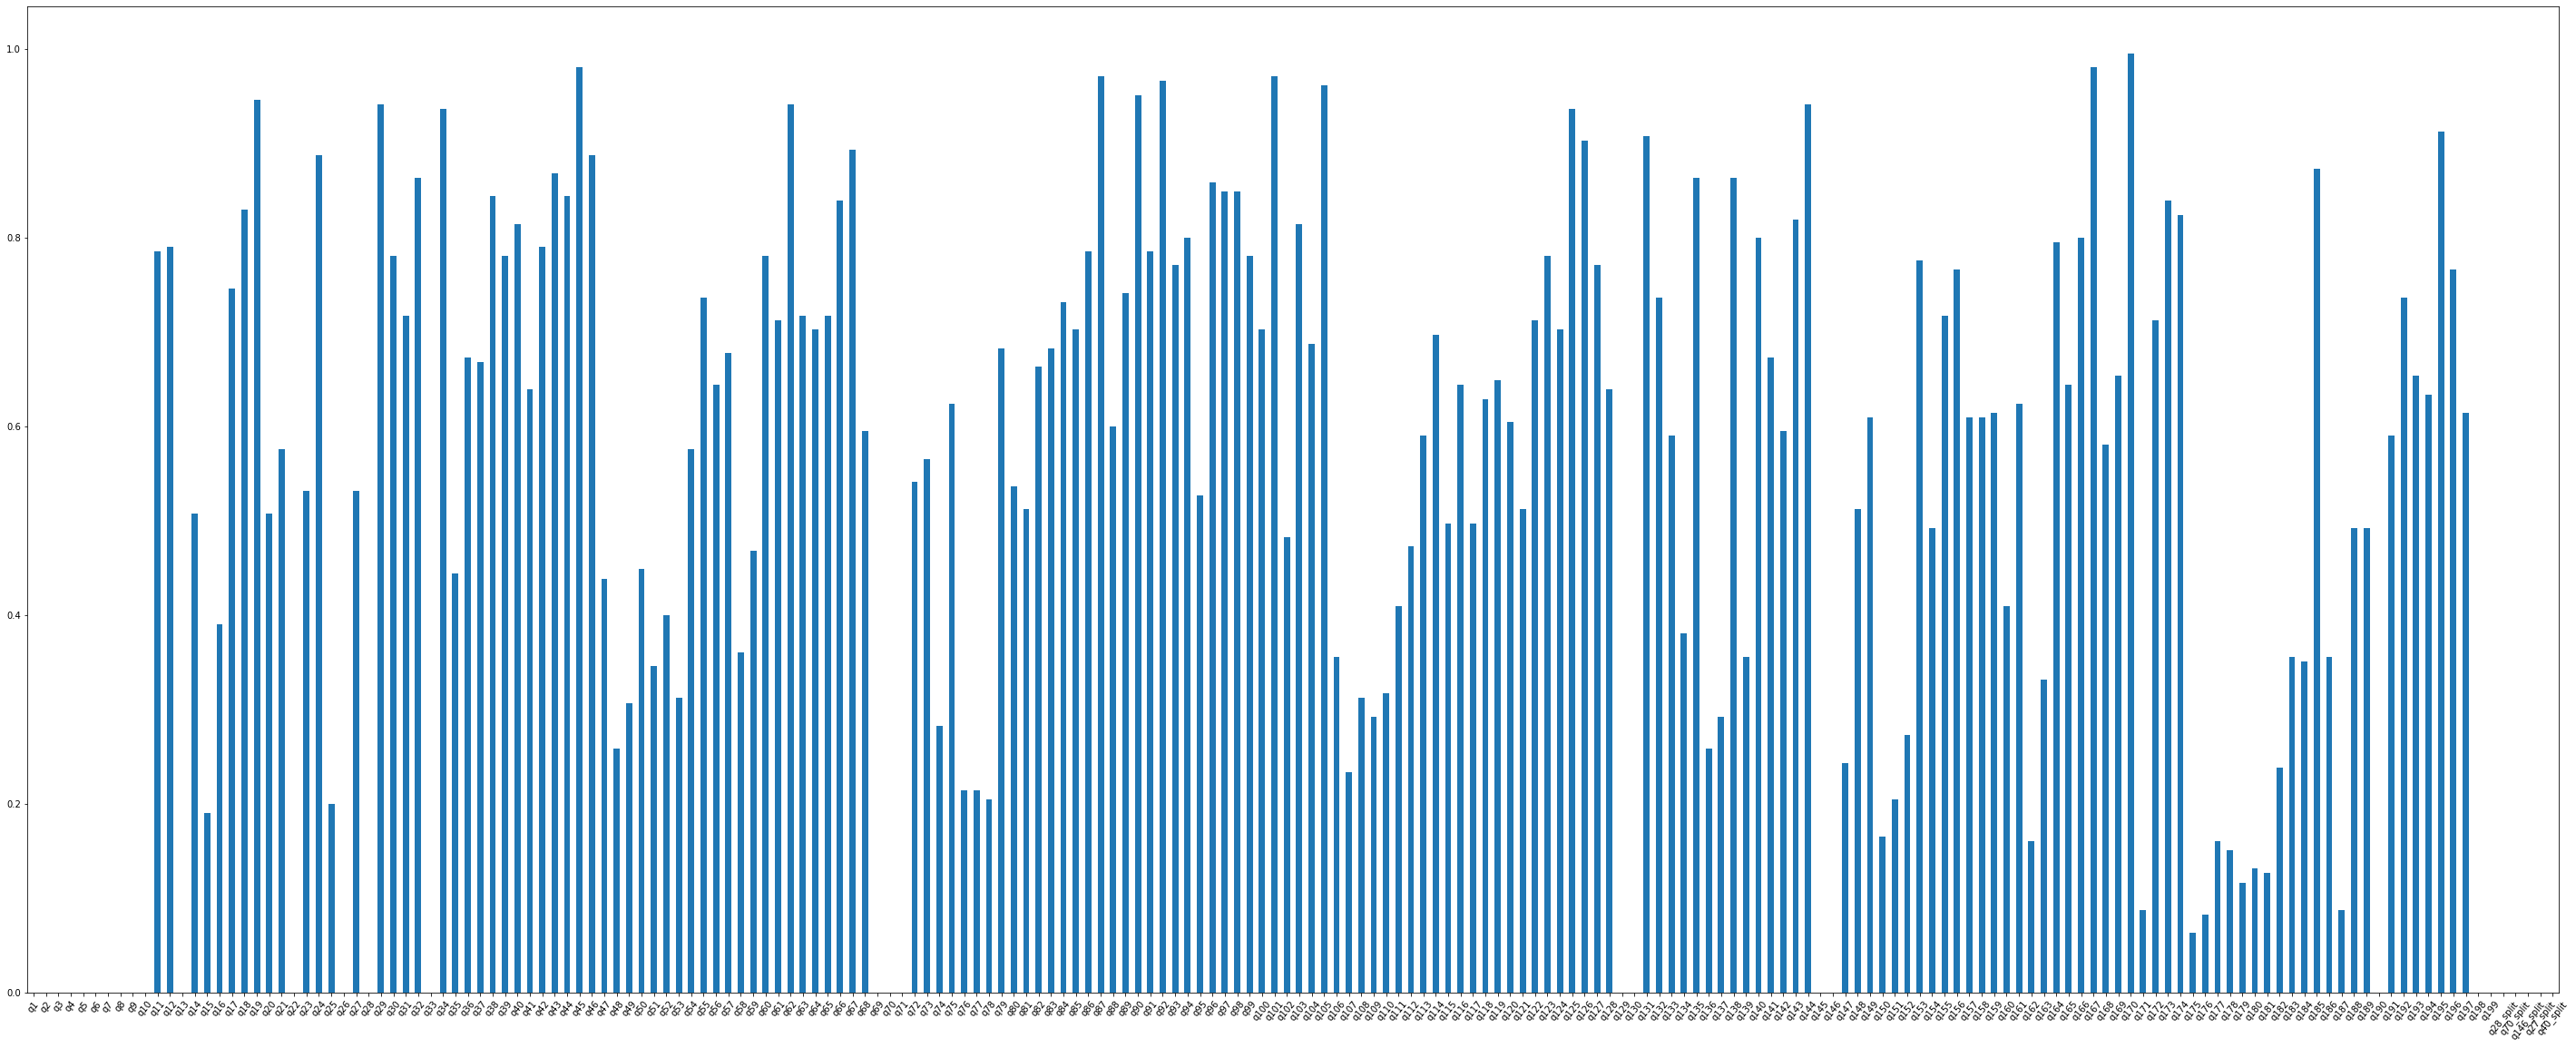

In [127]:
# visualize missingness

question_data_unlabeled = question_data.drop(columns=['id', 'nid'])
q_nullseries = question_data_unlabeled.isna().sum() / question_data_unlabeled.shape[0] # calculate % NaN per column
ax = q_nullseries.plot.bar(x='question', y='% missing', rot=50, figsize=(50,20)) # plot question vs. % missing

In [128]:
# collapse rows with the same ID by picking the one with the least missingness

for i in question_data.id.unique(): # for each unique id...
    temp = question_data[question_data.id == i].copy() # extract rows with corresponding id
    if temp.shape[0] > 1: # if there is more than one entry...
        idx = temp.isna().sum(axis=1).idxmin() # get the id of the row with min missing
        idxs = list(temp.index.values)
        idxs.remove(idx)
        question_data.drop(index=idxs, inplace=True)
        
question_data.shape

(123, 206)

In [129]:
# drop columns with a higher % missing than our threshold

cols_to_drop = []
    
for ind,val in q_nullseries.iteritems():
    if val > missingness_threshold:
        cols_to_drop.append(ind)

question_data.drop(columns=cols_to_drop, inplace=True)
question_data.shape

(123, 86)

In [130]:
outcomes = pd.read_stata('./data/full_cohort_with_clinical_outcomes.dta') # read outcome data
print(outcomes.shape)
outcomes.head()

(316, 310)


,ptid,center_ptid,var3,trr_id_code,sex,age,race,primarylanguage,insurance,drinksperday,yrsheavydrink,marital,psych,psychmed,smoke1illicit2,smoker,thc,rehab,famhx,job,legalhx,var22,var23,lastdrink,initial_hospdate,center_hospdate,listdate,ltdate,dischargedate,lastcontact,death,jaundice,jaundicedate,heavydrink,contributingcause,var36,therapy,therapyduration,steroid_whynot,lille_steroid,lille_nosteroid,osh_lab_date,sodium_osh,inr_osh,bili_osh,cr_osh,rrt_osh,meld_osh,maddrey_osh,var51,hosp_lab_date,sodium_hosp,inr_hosp,pt_hosp,pt_control,bili_hosp,cr_hosp,rrt_hosp,meld_hosp,maddrey_hosp,wbc,ast,alt,hcv,hbv,albumin,bun_hosp,map_hosp,vasopressor_hosp,pao2ratio_hosp,spo2ratio_hosp,list_lab_date,na_list,inr_list,bili_list,cr_list,rrt_list,meld_list,var80,lt_lab_date,na_lt,inr_lt,bili_lt,cr_lt,rrt_lt,meld_lt,pvt,albumin_lt,bun_lt,map_lt,vasopressor_lt,pao2ratio_lt,spo2_ratio,bmi,var96,vent,gib,ascites,encephalopathy,var101,var102,sepsis,sepsis_type,sepsis_pathogen,sepsis_site,pancreatitis,gib_ah,var109,inf,var111,vascular,biliary,rejection,var115,alc_postlt,alc_diag,binge_alc,freq_alc,stilldrinking,alc_postlt_date,othercomplications,var123,biopsy_recurrent,graftfailure,chronicrejection,prelt_biopsy,var128,var129,var130,var131,var132,var133,center,event,otherid,race_txt,primarylanguage_txt,psych_txt,psychmed_txt,illicit_txt,death_txt,contributingcause_txt,steroid,pentoxifylline,nac,steroid_days,pentoxifylline_days,nac_days,steroid_whynot_txt,vasopressor_hosp_txt,vasopressor_lt_txt,sepsis_date,sepsis_txt,pancreatitis_date,gib_ah_date,gib_ah_txt,inf1_type,inf1_date,inf1_pathogen,inf1_site,inf1_txt,inf2_type,inf2_date,inf2_pathogen,inf2_site,inf2_txt,vascular_date,vascular_txt,biliary_date,biliary_txt,rejection_date,rejection_txt,alc_diagtxt,biopsy_recurrent_date,prelt_biopsy_txt,graftfailure_txt,chronicrejection_txt,var48,var49,lt_date_update,hospdays,postlt_rrt,lost,fu_date_update,death_update,cod_txt,cod_alcohol,death_date_update,postlt_ah,lost_compliance,lost_transition,lost_txt,hospdeath,lastdrink_destring,initial_hospdate_destring,center_hospdate_destring,listdate_destring,ltdate_destring,dischargedate_destring,lastcontact_destring,osh_lab_date_destring,hosp_lab_date_destring,list_lab_date_destring,lt_lab_date_destring,alc_postlt_date_destring,rejection_date_destring,fu_time,fu_time_yrs,death_time,death_time_yrs,abstime,abstime_yrs,hosptime,alc_postlt_interval,alc_postlt_interval_yrs,rejection_time,rejection_time_yrs,caucasian,private,medicaid,medicare,tendrinksperday,fifteenyrsheavydrink,illicit,anyrehab,multiplerehab,anylegalhx,multiplelegalhx,anymarital,anyfamhx,overtencephalopathy,fu_sincelastdrink,sustained_alc,slip,harmfuldrink,ordinaldrink,_st,_d,_t,_t0,event_date,event_type,event_hosp,event_hospdate,event_drinksperday,event_drinkingdaysperweek,event_meld,event_ascites,event_overtencephalopathy,event_varicealbleeding,event_jaundice,event_sobriety,event_relapse,event_niaaa_jaundice,event_jaundicedate,event_niaaa_heavy,event_niaaa_contributing,event_niaaa_ast,event_niaaa_ratio,event_biopsy,var24,var25,event_hosp1_date,event_hosp1_reason,event_hosp2_date,event_hosp2_reason,event_hosp3_date,event_hosp3_reason,event_hosp4_date,event_hosp4_reason,event_hosp5_date,event_hosp5_reason,var38,var39,event_withdrawal,event_withdrawal_date,event_pancreatitis,event_pancreatitis_date,event_seizure,event_seizure_date,var46,event_aa,event_aa_date,event_outpatientrehab,event_outpatientrehab_date,event_inpatientrehab,event_inpatientrehab_date,event_med_date,var54,var55,var56,event_factor_txt,event_factor_young,event_factor_children,event_factor_social,event_factor_advocate,event_factor_other,var63,event_contributing_txt,event_biopsy_txt,event_type_txt,var37,var43,var52,var73,var81,var122,var127,explant_txt,_merge
0,1,1,,,1,44,0.0,0.0,0.0,5.0,20.0,0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,9/21/17,9/27/17,10/11/17,10/23/17,10/27/17,11/14/17,3/24/20,0,1.0,8/27/17,1.0,0.0,NaN,1,8,NaN,0.900,NaN,,134.0,1.50,22.299999,0.49,0.0,25.0,49.599998,NaN,10/

In [131]:
outcomes = outcomes[outcomes.hospdeath != 1] # remove patients who died in the hospital
outcomes.shape

(304, 310)

In [132]:
outcomes = outcomes[[outcome, 'ptid', 'center']]
outcomes.head()

,harmfuldrink,ptid,center
0,0.0,1,1
1,0.0,2,1
2,0.0,3,1
3,1.0,4,1
4,0.0,5,1


In [133]:
outcomes[outcome].value_counts() / outcomes.shape[0]

0.0    0.746711
1.0    0.161184
Name: harmfuldrink, dtype: float64

In [134]:
outcomes[outcome].value_counts()

0.0    227
1.0     49
Name: harmfuldrink, dtype: int64

In [135]:
combined = question_data.merge(outcomes, left_on='id', right_on='ptid', how='left') # merge with question data
print(combined.shape)
combined.head()

(123, 89)


,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q13,q15,q16,q22,q25,q26,q28,q33,q35,q47,q48,q49,q50,q51,q52,q53,q58,q59,q69,q70,q71,q74,q76,q77,q78,q102,q106,q107,q108,q109,q110,q111,q112,q115,q117,q129,q130,q134,q136,q137,q139,q145,q146,q147,q150,q151,q152,q154,q160,q162,q163,q171,q175,q176,q177,q178,q179,q180,q181,q182,q183,q184,q186,q187,q188,q189,q190,q198,q199,id,nid,q28_split,q70_split,q146_split,q27_split,q40_split,harmfuldrink,ptid,center
0,7,2,1,1,1,0,0,0,0,1,1,1.0,NaN,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0,0,0,8.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0,0,0.0,1.0,NaN,1.0,0,1,4.0,0.0,0.0,NaN,NaN,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1,0,0,1,47,0,0,1,0,0,0.0,1.0,1.0
1,7,2,1,1,1,0,0,0,0,1,2,0.0,2.0,0,0.0,0,0,0,NaN,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,NaN,NaN,NaN,0,0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,3,0,0,2,48,0,0,0,0,0,0.0,2.0,1.0
2,5,2,0,1,1,0,0,0,0,1,1,0.0,2.0,0,0.0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0,0,7.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,1.0,1.0,1.0,0,0,5.0,1.0,1.0,0.0,NaN,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1,0,0,3,49,1,0,0,0,0,0.0,3.0,1.0
3,8,2,1,0,1,0,0,0,0,1,2,1.0,2.0,0,0.0,0,2,0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1,0,2,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,0,0,1.0,1.0,1.0,1.0,1,0,NaN,0.0,0.0,0.0,NaN,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,0.0,NaN,1.0,2,1,0,4,81,1,0,0,0,0,1.0,4.0,1.0
4,13,2,1,1,1,0,0,0,1,1,2,0.0,2.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,NaN,1.0,1.0,1.0,0,3,5.0,1.0,0.0,NaN,NaN,3.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1.0,4,0,0,5,82,0,0,1,0,0,0.0,5.0,1.0


In [136]:
combined[outcome].isna().sum()

28

In [137]:
# combined.dropna(subset=[outcome], inplace=True) # drop patients with missing outcome data
combined[outcome].fillna(0, inplace=True) # replace missing outcome with 0 meaning no harmful drinking
combined.drop(inplace=True, columns=['id', 'ptid', 'nid']) # remove merging variables
print(combined.shape)
combined.head()

(123, 86)


,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q13,q15,q16,q22,q25,q26,q28,q33,q35,q47,q48,q49,q50,q51,q52,q53,q58,q59,q69,q70,q71,q74,q76,q77,q78,q102,q106,q107,q108,q109,q110,q111,q112,q115,q117,q129,q130,q134,q136,q137,q139,q145,q146,q147,q150,q151,q152,q154,q160,q162,q163,q171,q175,q176,q177,q178,q179,q180,q181,q182,q183,q184,q186,q187,q188,q189,q190,q198,q199,q28_split,q70_split,q146_split,q27_split,q40_split,harmfuldrink,center
0,7,2,1,1,1,0,0,0,0,1,1,1.0,NaN,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0,0,0,8.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0,0,0.0,1.0,NaN,1.0,0,1,4.0,0.0,0.0,NaN,NaN,3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1,0,0,0,0,1,0,0,0.0,1.0
1,7,2,1,1,1,0,0,0,0,1,2,0.0,2.0,0,0.0,0,0,0,NaN,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,NaN,NaN,NaN,0,0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,3,0,0,0,0,0,0,0,0.0,1.0
2,5,2,0,1,1,0,0,0,0,1,1,0.0,2.0,0,0.0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0,0,7.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,1.0,1.0,1.0,0,0,5.0,1.0,1.0,0.0,NaN,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1,0,0,1,0,0,0,0,0.0,1.0
3,8,2,1,0,1,0,0,0,0,1,2,1.0,2.0,0,0.0,0,2,0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1,0,2,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,0,0,1.0,1.0,1.0,1.0,1,0,NaN,0.0,0.0,0.0,NaN,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,0.0,NaN,1.0,2,1,0,1,0,0,0,0,1.0,1.0
4,13,2,1,1,1,0,0,0,1,1,2,0.0,2.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,NaN,1.0,1.0,1.0,0,3,5.0,1.0,0.0,NaN,NaN,3.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1.0,4,0,0,0,0,1,0,0,0.0,1.0


In [138]:
combined.to_csv('./data/data_final.csv')

In [139]:
X = combined.drop(columns=[outcome]) # extract predictors
y = combined[outcome] # extract outcome
print(X.shape, y.shape)

(123, 85) (123,)


In [140]:
X.isna().sum().sum()

1637

In [141]:
if imputation_strategy == '-1':
    X.fillna(-1, inplace=True) # replace NaN with -1 to signify ommitted question
elif imputation_strategy == 'mode':
    for col in X.columns:
        X[col].fillna(X[col].mode()[0], inplace=True)

In [142]:
X.isna().sum().sum()

0

In [143]:
y.isna().sum()

0

In [144]:
X.columns

Index(['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q13',
       'q15', 'q16', 'q22', 'q25', 'q26', 'q28', 'q33', 'q35', 'q47', 'q48',
       'q49', 'q50', 'q51', 'q52', 'q53', 'q58', 'q59', 'q69', 'q70', 'q71',
       'q74', 'q76', 'q77', 'q78', 'q102', 'q106', 'q107', 'q108', 'q109',
       'q110', 'q111', 'q112', 'q115', 'q117', 'q129', 'q130', 'q134', 'q136',
       'q137', 'q139', 'q145', 'q146', 'q147', 'q150', 'q151', 'q152', 'q154',
       'q160', 'q162', 'q163', 'q171', 'q175', 'q176', 'q177', 'q178', 'q179',
       'q180', 'q181', 'q182', 'q183', 'q184', 'q186', 'q187', 'q188', 'q189',
       'q190', 'q198', 'q199', 'q28_split', 'q70_split', 'q146_split',
       'q27_split', 'q40_split', 'center'],
      dtype='object')



Optimal number of features: 14


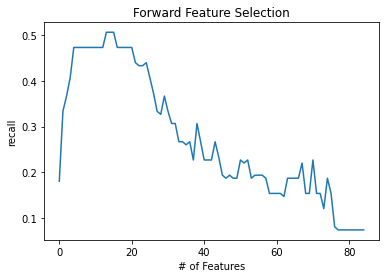

In [145]:
def forward_feature_selection(model, X, y):
    features = list(X.columns)
    selected_features = []
    scores = []
    
    for i in tqdm(range(X.shape[1])):
        best_score = 0
        next_feat = ''
        for feat in features:
            selected_features.append(feat)
            temp_X = X[selected_features]
            temp_scores = cross_validate(clone(model), temp_X, y, cv=5, scoring=['recall'])
            temp_score = temp_scores['test_recall'].mean()
            if temp_score >= best_score:
                best_score = temp_score
                next_feat = feat
            selected_features.pop()
        #print('Added Feature:', next_feat)
        selected_features.append(next_feat)
        features.remove(next_feat)
        scores.append(best_score)
        
    #print('Ordering of Features:', selected_features)
    
    plt.title('Forward Feature Selection')
    plt.xlabel('# of Features')
    plt.ylabel('recall')
    plt.plot(list(range(X.shape[1])), scores)
    return scores, selected_features

if include_feature_selection:
    scores, selected_features = forward_feature_selection(model, X, y)
    optimal_n_features = scores.index(max(scores)) + 1
    print('\nOptimal number of features:', optimal_n_features)
    optimal_features = selected_features[:optimal_n_features]
    X = X[optimal_features]

In [146]:
scores = cross_validate(clone(model), X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

print('Accuracy:', round(scores['test_accuracy'].mean(), 4))
print('Precision:', round(scores['test_precision'].mean(), 4))
print('Recall:', round(scores['test_recall'].mean(), 4))
print('AUC:', round(scores['test_roc_auc'].mean(), 4))

Accuracy: 0.8137
Precision: 0.66
Recall: 0.4733
AUC: 0.6961


In [147]:
model.fit(X, y)

RandomForestClassifier()

In [148]:
try:
    y = model.feature_importances_ # for Random Forest & XGBoost
except AttributeError:
    y = model.coef_[0] # for logistic regression

d = {'q': X.columns, 'feat_imp': y} # create feature importance dataframe
feat_imp = pd.DataFrame(data=d).sort_values(by='feat_imp', ascending=False)

In [149]:
def question_decoder(question_code):
    if '_split' in question_code:
        question_code = question_code.replace('_split','')
    question_code = question_code.upper()
    
    df = pd.read_excel('./data/Psychosocial data dictionary.xlsx', index_col=0)
    questions = df['QUESTIONS']
    try:
        return questions[question_code]
    except KeyError:
        return None

feat_imp['q_decoded'] = feat_imp['q'].apply(lambda x: question_decoder(x))
feat_imp

,q,feat_imp,q_decoded
0,q74,0.538327,"How many standard drink equivalents on average per day (during time period of heaviest drinking)?\nCALCULATOR:\n Beer or cooler: 12 oz = 1, 16 oz = 1.3, 22 oz = 2, 40 oz = 3.3\n Malt liquor: 8-9 oz = 1, 12 oz = 1.5, 16 oz = 2, 22 oz = 2.5, 40 oz = 4.5\n Table wine: 5 oz = 1, a 750 mL (25 oz) bottle = 5\n Hard liquor (80-proof spirits): 1.5 oz = 1, mixed drink = 1-3, pint (16 oz) = 11, fifth (25 oz) = 17, 1.75L (59 oz) = 39"
3,q150,0.106379,"Prior to onset of his or her recent symptoms, was the patient working or in school?"
4,q4,0.080722,Does the writer include direct patient quotes?
2,q70_split,0.069023,What is the writer's assessment of the severity of the patient's alcohol use disorder? (Enter 99 if not addressed.)
5,q179,0.058277,Does the patient currently live with his or her parent(s)?
1,q134,0.045305,Does the patient minimize his alcohol use / history?
9,q181,0.036934,Does the patient currently live with any extended (non-first-degree) family member aside from grandchildren?
11,q177,0.032989,Are there any adult children or grandchildren (>=18 years old) who live with the patient?
8,q145,0.027468,"Does the writer explicitly describe what the patient plans to do with his or her time instead of drinking (e.g., taking care of a relative, new hobby, more engaged with family or his or her religion, etc.)?"
6,q184,0.004575,What is the current health status of the patient's spouse or significant other? (Enter 99 if not applicable.)


In [153]:
if save_results:    
    now = datetime.now()
    current_time = now.strftime("(%H:%M:%S)")
    current_date = now.date().strftime("%b-%d")
    
    filename = current_date + current_time + ".html"
    print("saving results to " + filename)
    os.system("ipython nbconvert --to html mvp.ipynb")
    os.rename('mvp.html', "./raw_results/" + filename)

saving results to Apr-15(10:44:22).html
